# Setup

In [1]:
# check GPU
!nvidia-smi

Tue Jan 10 15:37:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout vgg_training

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 630, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 630 (delta 125), reused 137 (delta 79), pack-reused 389
Receiving objects: 100% (630/630), 27.22 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (372/372), done.
Branch 'vgg_training' set up to track remote branch 'vgg_training' from 'origin'.
Switched to a new branch 'vgg_training'


In [6]:
# pull the required files
!cd mode_connectivity && git lfs pull -I mode_connectivity/model_files/vgg_wm1_a.pt mode_connectivity/model_files/vgg_wm1_b.pt

In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from mode_connectivity.training import *
from mode_connectivity.lmc import *
from mode_connectivity.training_config import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.vgg import VGG
from mode_connectivity.models.resnet import ResNet

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils

import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# LMC

In [19]:
n_points = 20
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    VGG, 'mode_connectivity/model_files/vgg_wm1_a.pt', 'mode_connectivity/model_files/vgg_wm1_b.pt', 'cifar10', n_points=n_points, verbose=2, max_iter=50
)


Files already downloaded and verified
Files already downloaded and verified

performing naive interpolation
point 1/20. lam = 0.0, train loss = 0.08337548110961913, test loss = 0.33477783813476564
point 2/20. lam = 0.05263157933950424, train loss = 0.09234221740722656, test loss = 0.3097053405761719
point 3/20. lam = 0.10526315867900848, train loss = 0.13829643371582032, test loss = 0.32744033813476564
point 4/20. lam = 0.15789473056793213, train loss = 0.2493029296875, test loss = 0.41095696411132815
point 5/20. lam = 0.21052631735801697, train loss = 0.4787398559570312, test loss = 0.605723193359375
point 6/20. lam = 0.2631579041481018, train loss = 0.8939690295410156, test loss = 0.9715222290039063
point 7/20. lam = 0.31578946113586426, train loss = 1.4905666674804687, test loss = 1.519772900390625
point 8/20. lam = 0.3684210479259491, train loss = 2.0544278540039063, test loss = 2.043232666015625
point 9/20. lam = 0.42105263471603394, train loss = 2.309156032714844, test loss = 2.2

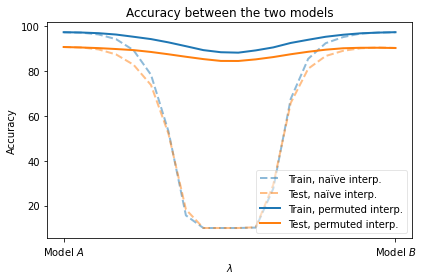

In [23]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

In [18]:
!cd mode_connectivity && git diff

diff --git a/model_files/vgg_wm1_a.pt b/model_files/vgg_wm1_a.pt
index d4d90f1..88caeaf 100644
Binary files a/model_files/vgg_wm1_a.pt and b/model_files/vgg_wm1_a.pt differ
diff --git a/model_files/vgg_wm1_b.pt b/model_files/vgg_wm1_b.pt
index a45914d..7404691 100644
Binary files a/model_files/vgg_wm1_b.pt and b/model_files/vgg_wm1_b.pt differ
diff --git a/models/vgg.py b/models/vgg.py
index fcc0b83..a0e58a5 100644
--- a/models/vgg.py
+++ b/models/vgg.py
@@ -94,7 +94,6 @@ class VGG(nn.Module):
                     )
                     for i in range(len(is_conv))
                 },
-                **{f"features.{i}.bias": (f"P_Conv_{i}",) for i in is_conv + [0]},
                 # layer norms
                 **{
                     f"features.{is_norm[i]}.weight": (f"P_Conv_{is_conv[i]}", None)
@@ -106,9 +105,10 @@ class VGG(nn.Module):
                 },
                 # classifier
                 "classifier.0.weight": ("P_Dense_0", f"P_Conv_{is_conv[-1]}"),
+             